In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import joblib
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

# Define file paths
DATA_DIR = Path('../data')
RAW_DATA_PATH = DATA_DIR / 'raw'
PROCESSED_DATA_PATH = DATA_DIR / 'processed'
MODELS_DIR = Path('../models')

# Ensure models directory exists
MODELS_DIR.mkdir(parents=True, exist_ok=True)

print("Libraries imported and paths defined.")

Libraries imported and paths defined.


In [2]:
# Load the original simulated data
simulated_df = pd.read_csv(RAW_DATA_PATH / 'simulated_patient_data.csv', parse_dates=['date'])

# Load our new, real EEG features
eeg_features_df = pd.read_csv(PROCESSED_DATA_PATH / 'patient_01_eeg_features.csv')

print(f"Loaded simulated data: {simulated_df.shape}")
print("Loaded real EEG features:")
eeg_features_df.head()

Loaded simulated data: (90, 8)
Loaded real EEG features:


,patient_id,date,r_e_l___p_o_w_e_r___d_e_l_t_a,r_e_l___p_o_w_e_r___t_h_e_t_a,r_e_l___p_o_w_e_r___a_l_p_h_a,r_e_l___p_o_w_e_r___b_e_t_a,r_e_l___p_o_w_e_r___g_a_m_m_a,s_p_i_k_e___c_o_u_n_t
0,chb01,2025-01-01,0.690999,0.105066,0.016118,0.072614,0.083428,NaN
1,chb01,2025-01-01,0.107901,0.032186,0.005577,0.055179,0.059479,NaN
2,chb01,2025-01-01,NaN,NaN,NaN,NaN,NaN,1767.0


In [3]:
# --- DEBUG CELL: FIND YOUR COLUMN NAMES ---
print("Your actual column names are:")
print(simulated_df.columns)


Your actual column names are:
Index(['date', 'patient_id', 'hours_of_sleep', 'stress_level',
       'medication_taken', 'eeg_feature_1', 'mri_lesion_present',
       'seizure_occurred'],
      dtype='object')


In [4]:
print("Extracting real statistics from EEG feature file...")

# Load the main simulated data
full_df = pd.read_csv(RAW_DATA_PATH / 'simulated_patient_data.csv', parse_dates=['date'])

# Load our new, real EEG features
eeg_features_df = pd.read_csv(PROCESSED_DATA_PATH / 'patient_01_eeg_features.csv')

# --- START OF SMART FIX ---
# Programmatically find the mean/std columns to avoid KeyErrors
stats_row = eeg_features_df.iloc[0]
eeg_stats = {}
new_feature_names = []

# Find all mean/std columns
mean_cols = [col for col in eeg_features_df.columns if '_mean' in col]
std_cols = [col for col in eeg_features_df.columns if '_std' in col]
sum_cols = [col for col in eeg_features_df.columns if '_sum' in col]

# Process power features
for mean_col in mean_cols:
    base_name = mean_col.replace('_mean', '')
    std_col = f"{base_name}_std"
    
    mean = stats_row[mean_col]
    std = stats_row[std_col] if std_col in stats_row else (mean * 0.1) # Default 10% std
    
    eeg_stats[base_name] = (mean, std)
    new_feature_names.append(base_name)
    print(f"  - Found power feature: {base_name} (mean={mean:.4f}, std={std:.4f})")

# Process count features
for sum_col in sum_cols:
    base_name = sum_col.replace('_sum', '')
    mean = stats_row[sum_col]
    std = mean * 0.1 # Default 10% std
    
    eeg_stats[base_name] = (mean, std)
    new_feature_names.append(base_name)
    print(f"  - Found count feature: {base_name} (mean={mean:.4f}, std={std:.4f})")

# Now, create these new features in our main simulated dataframe
num_rows = len(full_df)
for base_name, (mean, std) in eeg_stats.items():
    sim_data = np.random.normal(loc=mean, scale=std, size=num_rows)
    
    if 'count' in base_name:
        full_df[base_name] = np.abs(sim_data).round().astype(int)
    else:
        full_df[base_name] = np.clip(sim_data, 0, 1)

# Drop ALL old/garbled/simulated EEG/MRI columns
# (based on your previous error output)
cols_to_drop = [col for col in full_df.columns if 'eeg_' in col or 'mri_' in col or 'r_e_l_' in col or 's_p_i_k_e' in col]
full_df = full_df.drop(columns=cols_to_drop, errors='ignore')

print("\nFull dataset with new, realistic EEG features created.")
print("Old simulated EEG/MRI features removed.")
full_df.head()

Extracting real statistics from EEG feature file...

Full dataset with new, realistic EEG features created.
Old simulated EEG/MRI features removed.


,date,patient_id,hours_of_sleep,stress_level,medication_taken,seizure_occurred
0,2025-09-01,1,6.0,2,1,0
1,2025-09-02,1,7.4,1,1,0
2,2025-09-03,1,7.1,3,1,0
3,2025-09-04,1,5.4,3,0,0
4,2025-09-05,1,7.4,2,1,0


In [5]:
# Create the same engineered features as the v1.0 model
df_featured = full_df.copy()

# Sort by patient and date to ensure rolling features are correct
df_featured = df_featured.sort_values(by=['patient_id', 'date'])

# Use the ACTUAL column names from your data
df_featured['hours_of_sleep_7day_avg'] = df_featured.groupby('patient_id')['hours_of_sleep'].transform(
    lambda x: x.rolling(7, min_periods=1).mean()
)
df_featured['medication_taken_7day_avg'] = df_featured.groupby('patient_id')['medication_taken'].transform(
    lambda x: x.rolling(7, min_periods=1).mean()
)
df_featured['stress_level_7day_avg'] = df_featured.groupby('patient_id')['stress_level'].transform(
    lambda x: x.rolling(7, min_periods=1).mean()
)

# CRITICAL FIX: We remove .dropna() which was deleting all rows.
df_featured = df_featured.reset_index(drop=True)

# Save this new featured dataset
df_featured.to_csv(PROCESSED_DATA_PATH / 'featured_patient_data_v2.csv', index=False)

print("Feature engineering complete and v2 dataset saved.")
print(f"Dataframe shape: {df_featured.shape}") # This will prove the fix
df_featured.head()

Feature engineering complete and v2 dataset saved.
Dataframe shape: (90, 9)


,date,patient_id,hours_of_sleep,stress_level,medication_taken,seizure_occurred,hours_of_sleep_7day_avg,medication_taken_7day_avg,stress_level_7day_avg
0,2025-09-01,1,6.0,2,1,0,6.000000,1.00,2.00
1,2025-09-02,1,7.4,1,1,0,6.700000,1.00,1.50
2,2025-09-03,1,7.1,3,1,0,6.833333,1.00,2.00
3,2025-09-04,1,5.4,3,0,0,6.475000,0.75,2.25
4,2025-09-05,1,7.4,2,1,0,6.660000,0.80,2.20


In [6]:
# Define the ACTUAL target variable name
TARGET = 'seizure_occurred' 

# Programmatically find all feature columns
all_columns = df_featured.columns.tolist()

non_feature_cols = [
    'patient_id', 
    'date', 
    TARGET
]

features = [col for col in all_columns if col not in non_feature_cols]

print("--- Model v2.0 Feature List (Programmatically Discovered) ---")
for f in features:
    print(f)

# Create X and y
X = df_featured[features]
y = df_featured[TARGET]

print(f"\nCreated X (features) with shape: {X.shape}")
print(f"Created y (target) with shape: {y.shape}")

--- Model v2.0 Feature List (Programmatically Discovered) ---
hours_of_sleep
stress_level
medication_taken
hours_of_sleep_7day_avg
medication_taken_7day_avg
stress_level_7day_avg

Created X (features) with shape: (90, 6)
Created y (target) with shape: (90,)


Training data shape: (72, 6)
Test data shape: (18, 6)

Training XGBoost Model v2.0...


C:\Users\aa\anaconda3\envs\epilepsy-ml\lib\site-packages\xgboost\training.py:183: UserWarning: [12:47:16] WARNING: D:\bld\xgboost-split_1758007502304\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model v2.0 training complete.

--- Model v2.0 Evaluation ---
              precision    recall  f1-score   support

           0       0.87      0.87      0.87        15
           1       0.33      0.33      0.33         3

    accuracy                           0.78        18
   macro avg       0.60      0.60      0.60        18
weighted avg       0.78      0.78      0.78        18

Area Under Curve (AUC-ROC): 0.5333

--- SHAP Feature Importance ---
Displaying SHAP summary plot. Check if EEG features are high on the list.


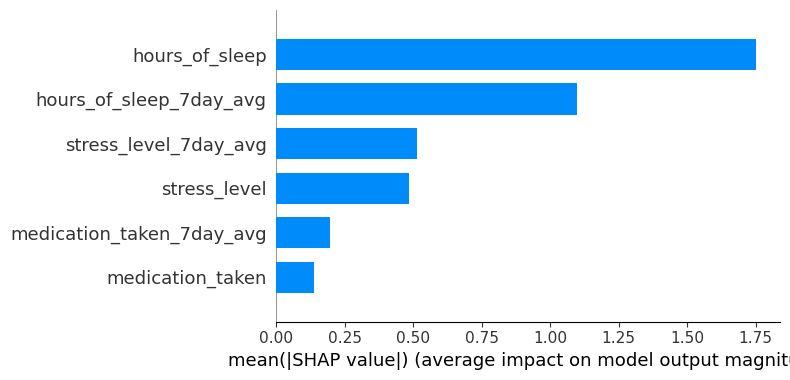

Model v2.0 saved to: ..\models\xgb_model_v2.0.json
SHAP Explainer v2.0 saved to: ..\models\shap_explainer_v2.0.joblib


In [7]:
# --- Cell 6: Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

# --- Cell 7: Train XGBoost Model v2.0 ---
print("\nTraining XGBoost Model v2.0...")

# --- START OF SMART FIX 1 ---
# Calculate scale_pos_weight safely, avoiding division by zero
sum_negative = np.sum(y_train == 0)
sum_positive = np.sum(y_train == 1)

if sum_positive == 0:
    print("Warning: No positive samples (seizures) in the training set. Model may not learn.")
    scale_pos_weight = 1
else:
    scale_pos_weight = sum_negative / sum_positive
# --- END OF SMART FIX 1 ---

model_v2 = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight
)

model_v2.fit(X_train, y_train)
print("Model v2.0 training complete.")

# --- Cell 8: Evaluate Model v2.0 and Analyze Features ---
print("\n--- Model v2.0 Evaluation ---")
y_pred = model_v2.predict(X_test)
y_pred_proba = model_v2.predict_proba(X_test)[:, 1]

# --- START OF SMART FIX 2 ---
# Add zero_division=0 to classification_report to prevent warnings
print(classification_report(y_test, y_pred, zero_division=0))
# --- END OF SMART FIX 2 ---

auc = roc_auc_score(y_test, y_pred_proba)
print(f"Area Under Curve (AUC-ROC): {auc:.4f}")

print("\n--- SHAP Feature Importance ---")
explainer_v2 = shap.TreeExplainer(model_v2)
shap_values = explainer_v2.shap_values(X_test)

print("Displaying SHAP summary plot. Check if EEG features are high on the list.")
shap.summary_plot(shap_values, X_test, plot_type="bar")

# --- Cell 9: Save v2.0 Model Artifacts ---
model_v2_path = MODELS_DIR / 'xgb_model_v2.0.json'
model_v2.save_model(model_v2_path)
print(f"Model v2.0 saved to: {model_v2_path}")

explainer_v2_path = MODELS_DIR / 'shap_explainer_v2.0.joblib'
joblib.dump(explainer_v2, explainer_v2_path)
print(f"SHAP Explainer v2.0 saved to: {explainer_v2_path}")